In [1]:
import os

import numpy as np
import torch
import torchvision.datasets as dset
import torch.nn as nn
import torchvision.transforms as transforms

import pyro
import pyro.distributions as dist
import pyro.contrib.examples.util  # patches torchvision
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam


In [2]:
# デバッグに便利なエラーを出力する。重いので、本格的に学習するときはoffにしておく
pyro.enable_validation(True) 
pyro.distributions.enable_validation(False)
# seed値の設定
pyro.set_rng_seed(0)

In [3]:
# mnistのロードとバッチ化
def setup_data_loaders(batch_size=128, use_cuda=True):
    root = "./data"
    download = True

    trans = transforms.ToTensor() # 正規化
    train_set = dset.MNIST(root=root, train=True, transform=trans, download=download)
    test_set = dset.MNIST(root=root, train=False, transform=trans)
    
    kwargs = { 'num_workers': 1, "pin_memory": use_cuda }
    train_loader = torch.utils.data.DataLoader(dataset=train_set,
        batch_size=batch_size, shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(dataset=test_set,
        batch_size=batch_size, shuffle=False, **kwargs)
    return train_loader, test_loader

In [4]:
class Decoder(nn.Module):
    def __init__(self, z_dim, hidden_dim):
        super().__init__()
        
        self.fc1 = nn.Linear(z_dim, hidden_dim)
        self.fc2_1 = nn.Linear(hidden_dim, 28*28)
        
        self.softplus = nn.Softplus() # NOTE: Reluだとどうなるのか
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, z):
        hidden = self.softplus(self.fc1(z))
        loc_img = self.sigmoid(self.fc2_1(hidden))
        return loc_img

In [5]:
class Encoder(nn.Module):
    def __init__(self, z_dim, hidden_dim):
        super().__init__()
        
        self.fc1 = nn.Linear(28*28, hidden_dim)
        self.fc2_1 = nn.Linear(hidden_dim, z_dim)
        self.fc2_2 = nn.Linear(hidden_dim, z_dim)

        self.softplus = nn.Softplus() # NOTE: Reluだとどうなるのか
        
    def forward(self, x):
        x = x.reshape(-1, 28*28)
        
        hidden = self.softplus(self.fc1(x))

        z_loc = self.fc2_1(hidden)
        z_scale = torch.exp(self.fc2_2(hidden))
        return z_loc, z_scale

In [6]:
class VAE(nn.Module):
    def __init__(self, z_dim=50, hidden_dim=400, use_cuda=True):
        super().__init__()
        # エンコーダ、デコーダーの設定
        self.encoder = Encoder(z_dim, hidden_dim)
        self.decoder = Decoder(z_dim, hidden_dim)
        
        if use_cuda:
            self.cuda()
        self.use_cuda = use_cuda
        self.z_dim = z_dim
    
    # モデル: p(x, z) = p(x|z)p(z)の定義
    def model(self, x):
        """
        Args:
            x: ミニバッチ (batch_size, 28, 28)
        """
        pyro.module("decoder", self.decoder) # pyro.moduleに登録(Pyroがデコーダー内のパラメータを扱えるようになる)
        
        # plateを使うことでミニバッチ内の各画像同士は独立であることを表現する
        with pyro.plate("data", x.shape[0]):
            # 事前確率p(z)のパラメータを設定する
            z_loc = x.new_zeros(torch.Size((x.shape[0], self.z_dim)))
            z_scale = x.new_ones(torch.Size((x.shape[0], self.z_dim)))
        
            # 多次元ガウス分布p(z)から潜在変数zのサンプリングを行う
            # NOTE: to_event(1)ってなに？
            # ANS: 一次元ガウス分布ではなく、多次元ガウス分布からのサンプリングであることを表現している
            z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))
            
            # Decoder: z -> x_{dec}
            loc_img = self.decoder.forward(z)

            # x_{dec}とxのスコアを計算する
            # NOTE: ベルヌーイ分布はどこから出てきたの？
            # NOTE: 多変量ベルヌーイ分布について想像が付かない
            score = pyro.sample("obs", dist.Bernoulli(loc_img).to_event(1), obs=x.reshape(-1, 784))
            
            return loc_img

    def guide(self, x):
        pyro.module("encoder", self.encoder) # pyro.moduleに登録
        
        with pyro.plate("data", x.shape[0]):
            # Encoder: x->  多次元ガウス分布p(z)のパラメータ
            z_loc, z_scale = self.encoder.forward(x)

            # 多次元ガウス分布p(z)から潜在変数zのサンプリングを行う
            pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))

    def reconstruct_img(self, x):
        # Encoder: x->  多次元ガウス分布p(z)のパラメータ
        z_loc, z_scale = self.encoder(x)
        
        # 多次元ガウス分布p(z)から潜在変数zのサンプリングを行う
        z = dist.Normal(z_loc, z_scale).sample()

        # Decoder: z -> x_{dec}
        loc_img = self.decoder(z)
        return loc_img



In [7]:
vae = VAE()
optimizer = Adam({"lr": 1.0e-3})
svi = SVI(vae.model, vae.guide, optimizer, loss=Trace_ELBO())

In [8]:
def train(svi, train_loader, use_cuda=False):
    epoch_loss = 0.

    for x, _ in train_loader:
        if use_cuda:
            x = x.cuda()
        epoch_loss += svi.step(x)

    normalizer_train = len(train_loader.dataset)
    total_epoch_loss_train = epoch_loss / normalizer_train
    return total_epoch_loss_train

In [9]:
def evaluate(svi, test_loader, use_cuda=False):
    test_loss = 0.

    for x, _ in test_loader:

        if use_cuda:
            x = x.cuda()

        test_loss += svi.evaluate_loss(x)
    normalizer_test = len(test_loader.dataset)
    total_epoch_loss_test = test_loss / normalizer_test
    return total_epoch_loss_test

In [10]:
# ハイパーパラメータの定義
LEARNING_RATE = 1.0e-3
NUM_EPOCHS =100
TEST_FREQUENCY = 5

USE_CUDA = True

In [11]:
train_loader, test_loader = setup_data_loaders(batch_size=256, use_cuda=USE_CUDA)

# パラメータの初期化
pyro.clear_param_store()

vae = VAE(use_cuda=USE_CUDA)

adam_args = {"lr": LEARNING_RATE}
optimizer = Adam(adam_args)

svi = SVI(vae.model, vae.guide, optimizer, loss=Trace_ELBO())

train_elbo = []
test_elbo = []
for epoch in range(NUM_EPOCHS):
    total_epoch_loss_train = train(svi, train_loader, use_cuda=USE_CUDA)
    train_elbo.append(-total_epoch_loss_train)
    print("[epoch %03d]  average training loss: %.4f" % (epoch, total_epoch_loss_train))

    if epoch % TEST_FREQUENCY == 0:
        total_epoch_loss_test = evaluate(svi, test_loader, use_cuda=USE_CUDA)
        test_elbo.append(-total_epoch_loss_test)
        print("[epoch %03d] average test loss: %.4f" % (epoch, total_epoch_loss_test))

[epoch 000]  average training loss: 190.9314
[epoch 000] average test loss: 155.9965
[epoch 001]  average training loss: 146.7358
[epoch 002]  average training loss: 132.5769
[epoch 003]  average training loss: 124.0651
[epoch 004]  average training loss: 118.9689
[epoch 005]  average training loss: 115.5881
[epoch 005] average test loss: 113.4225
[epoch 006]  average training loss: 113.2782
[epoch 007]  average training loss: 111.7045
[epoch 008]  average training loss: 110.4743
[epoch 009]  average training loss: 109.4423
[epoch 010]  average training loss: 108.7002
[epoch 010] average test loss: 107.5987
[epoch 011]  average training loss: 108.0115
[epoch 012]  average training loss: 107.4387
[epoch 013]  average training loss: 107.0369
[epoch 014]  average training loss: 106.6394
[epoch 015]  average training loss: 106.2636
[epoch 015] average test loss: 105.7384
[epoch 016]  average training loss: 105.9814
[epoch 017]  average training loss: 105.6996
[epoch 018]  average training 

In [28]:
def draw_digit(data, row, col, n):
    size = 28
    plt.subplot(row, col, n)
    plt.imshow(data)
    plt.gray()

In [29]:
test_imgs = []
reco_imgs = []
for x, _ in test_loader:
    for index in range(100):
        test_img = x[index, :].to("cuda")
        reco_img = vae.reconstruct_img(test_img)
        test_imgs.append(test_img.reshape(28, 28).detach().cpu().numpy())
        reco_imgs.append(reco_img.reshape(28, 28).detach().cpu().numpy())
    break

## 元の画像

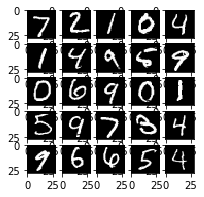

In [39]:
show_size = 5
total = 0
plt.figure(figsize=(3,3))
for i in range(show_size):
    for j in range(show_size):
        draw_digit(test_imgs[total], show_size, show_size, total+1)
        total += 1
plt.show()

## VAEを通した後の画像

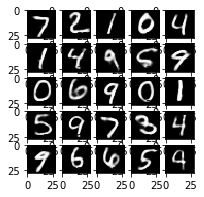

In [40]:
show_size = 5
total = 0
plt.figure(figsize=(3,3))
for i in range(show_size):
    for j in range(show_size):
        draw_digit(reco_imgs[total], show_size, show_size, total+1)
        total += 1
plt.show()